# AEWS Python Notebook 08g: AEWS miscellanea

**Author**: Eric Lehmann, CSIRO Data61  
**Date**:  July 08, 2016 (slight update: July 15, 2016)

**Note**: The Python code below is "rudimentary" etc. etc. Priority is here given to code interpretability rather than execution efficiency.

**Note**: this notebook should be accessible and viewable at [https://github.com/eric542/agdc_v2/tree/master/notebooks](https://github.com/eric542/agdc_v2/tree/master/notebooks).

## Summary

Building up on the concepts introduced in the previous notebooks in this series, we work out the remaining components of the AEWS implementation &mdash; see *'AEWS Python Notebook 08a'* for details of these components. The contents summary for the present notebook is given below.

**Abstract** &mdash; This notebook (08g) investigates the issue of PQ masking in more depth (see also _'AEWS Python Notebook 05'_ for instance). In particular, we check how the original PQ mask is "expanded" in the AGDC v2.0 API's masking function, and whether a "manually generated" mask might be more appropriate. The code written to manually mask the Landsat data is also helpful in dealing with the issue of missing PQ dates identified in earlier notebooks with the currently used (pre-release) database.


## Preliminaries

This (Jupyter) notebook was written for use on the NCI's VDI system, with the following pre-loaded module:

```
 $ module use /g/data/v10/public/modules/modulefiles --append
 $ module load agdc-py2-prod 
```

**NOTE**: the specific module loaded here (`agdc-py2-prod`) is different from the module loaded in earlier notebooks (`agdc-py2-dev`)! While the earlier module contained only Landsat 5 data, the `agdc-py2-prod` module links to a (different) AGDC database containing the following NBART/NBAR/PQA datasets:

* Landsat 8: 2013
* Landsat 7: 2013
* Landsat 5: 2006/2007

It is unclear whether the API functions in these 2 modules are identical or represent different versions.

**NOTE 2**: as of mid-June 2016, changes were made to the AGDC API v2.0, and the above Landsat datasets (and related API functions) can now be accessed through the module `agdc-py2-prod/1.0.3` (pre-major-change version). How long this module will remain accessible and/or when it will be replaced with the formal v2.0 API is still unclear at this time (June 2016).

In [1]:
%%html  # Definitions for some pretty text boxes...
<style> 
    div.warn { background-color: #e8c9c9; border: 1px solid #c27070; border-left: 6px solid #c27070; padding: 0.5em }
    div.note { background-color: #cce0ff; border: 1px solid #5c85d6; border-left: 6px solid #5c85d6; padding: 0.5em }
    div.info { background-color: #ffe680; border: 1px solid #cca300; border-left: 6px solid #cca300; padding: 0.5em }
</style>

In [2]:
%matplotlib inline
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np
import ogr, gdal, osr

from pylab import rcParams
rcParams['figure.figsize'] = (8,8)   # increase plot size a bit...
rcParams['axes.formatter.useoffset'] = False   # disable scalar formatter / offset in axes labels

from pprint import pprint
from __future__ import print_function

import datacube.api   # import the AGDC v2 API, with pre-loaded 'agds-py2-dev' (or similar) NCI module
from datacube.analytics.analytics_engine import AnalyticsEngine
from datacube.execution.execution_engine import ExecutionEngine

from scipy import ndimage
from scipy.spatial.distance import pdist

def expand_mask(mask_arr, npix):
    # Uses the True/False (masked/non-masked) values in the array 'mask_arr' and 
    # expands the True values spatially by 'npix' pixels. The value 'npix' can be
    # non-integer, i.e. the mask can be expanded by any spatial distance.
    nmid = np.floor(npix)
    nmax = int( nmid*2 + 1 )
    struc = np.zeros((nmax, nmax), dtype='bool')
    for ii in range(nmax):   # create desired binary structure for morphological operation
        for jj in range(ii,nmax):
            if pdist( [[nmid,nmid], [ii,jj]] ) <= npix:
                struc[ii,jj] = True
                struc[jj,ii] = True
    return ndimage.binary_dilation(mask_arr, structure=struc)

def merge_dup_dates(xada):
    # Takes in an xarray.DataArray 'xada' as input and merges 
    # datasets (time slices) within it that have the same dates.
    # Returns the modified DataArray and vector of selected dates.
    dates = xada.coords['time'].values
    n_dates = len( dates )
    
    # Convert UTM times to local dates (d/m/y only):
    str_dates = np.zeros(n_dates).astype('str')
    for ii in range(n_dates):
        str_dates[ii] = str( dates[ii] )[:10]
    
    # Remove duplicated dates:
    rem_ind = np.zeros(n_dates).astype('bool')   # keep track of which duplicated dates to remove
    for ind in range(1,n_dates):
        dup_ind = np.where( str_dates[:ind]==str_dates[ind] )[0]   # check for duplicated date up to current index
        if len( dup_ind )!=0:   # found (at least) one duplicate
            dup_ind = dup_ind[0]   # only use the first index if multiple dates returned
            rem_ind[ind] = True    # remove current date index
            ind_n_nans = np.sum( np.isnan( xada[ind] ) ) # nr of NaN pixels in each image
            dup_n_nans = np.sum( np.isnan( xada[dup_ind] ) )
            if ind_n_nans==0:     # current data has no NaN's, use it instead of duplicate date (copy it to lowest index)
                xada[dup_ind] = xada[ind]
            elif dup_n_nans!=0:   # if duplicate date has no NaN's: do nothing (use it instead of current date)
                if dup_n_nans<ind_n_nans:   # duplicate date has less NaN's: fill it in with current data
                    tmp = np.where( np.isnan(xada[dup_ind]) )
                    xada[dup_ind].values[tmp] = xada[ind].values[tmp]
                else:   # dup_n_nans>=ind_n_nans -- duplicate date has more NaN's: use it to fill in current data
                    tmp = np.where( np.isnan(xada[ind]) )
                    xada[ind].values[tmp] = xada[dup_ind].values[tmp]
                    xada[dup_ind] = xada[ind]   # save results to lowest date index, in case >2 slices have same date
    
    return xada[~rem_ind]

## Close look at the PQ mask

We'll use an example ROI defined in a previous notebook, namely the Wongalara lake in NSW, for a date found to have only a few specific pixels masked out by the AGDC API's pixel quality layer. This will help understand the PQ masking processes used in the current API.

In [3]:
lakes_file = '../NSW_lakes/NSW_WaterBody.shp'
lakes_vec = ogr.Open(lakes_file)
lakes_lyr = lakes_vec.GetLayer(0)

n_ftr = lakes_lyr.GetFeatureCount()
lname_list = list()
for kk in range( n_ftr ):
    ftr = lakes_lyr.GetFeature(kk)
    lname_list.append(ftr.GetField('hydroname'))

ftr = lname_list.index('WONGALARA')
lakes_ftr = lakes_lyr.GetFeature(ftr)
ring = lakes_ftr.GetGeometryRef().GetGeometryRef(0)
poly_array = np.array(ring.GetPoints())[:,0:2]  # lon / lat coords of polygon

In [4]:
dimensions = { 'lon' : { 'range': ( min(poly_array[:,0])-0.02, max(poly_array[:,0])+0.02 ) },
               'lat' : { 'range': ( max(poly_array[:,1])+0.02, min(poly_array[:,1])-0.02 ) },
               'time': { 'range': ((2013, 7, 1), (2013, 7, 10)) } }

In [5]:
ae = AnalyticsEngine()
ee = ExecutionEngine()

aeB2 = ae.create_array(('LANDSAT_8', 'nbar'), ['band_3'], dimensions, 'aeB2')
aeB3 = ae.create_array(('LANDSAT_8', 'nbar'), ['band_4'], dimensions, 'aeB3')
aePQ = ae.create_array(('LANDSAT_8', 'pqa'), ['pixelquality'], dimensions, 'aePQ')
aeWQ = ae.apply_expression([aeB2, aeB3], '((array1 + array2) * 0.5)', 'aeWQ')
aeWQ_PQmsk = ae.apply_expression([aeWQ, aePQ], 'array1{array2}', 'aeWQ_PQmsk')
ee.execute_plan(ae.plan)

INFO:datacube.analytics.analytics_engine:Initialise Analytics Module.
INFO:datacube.execution.execution_engine:Initialise Execution Module.


In [6]:
# Extracting the data of interest:
PQ_xarray = ee.cache['aePQ']['array_result']['pixelquality']
WQ_xarray = ee.cache['aeWQ']['array_result']['aeWQ']
WQ_pqm_xarray = ee.cache['aeWQ_PQmsk']['array_result']['aeWQ_PQmsk']

Here, we can visually investigate the resulting datasets (there are only three "dates" due to the short time window selected).

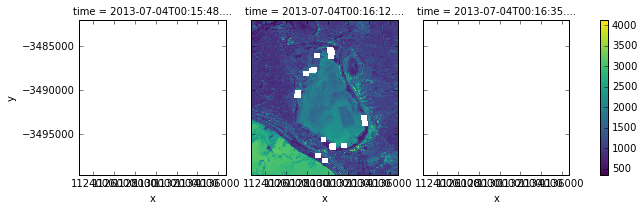

In [7]:
WQ_pqm_xarray.plot(col='time');

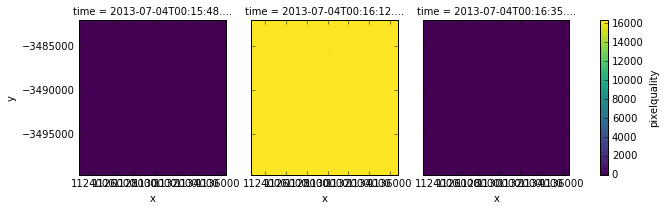

In [8]:
PQ_xarray.plot(col='time');

Note that we have not removed / merged the duplicate dates in the datasets (as it happens, only the second time slice contains valid data). However, this exercise highlights the fact that the PQ and Landsat datasets have different characteristics in terms of valid (i.e. non-NaN) data. If carried out independently for both datasets, the process of removing / merging duplicate dates will generate erroneous results. 

For instance, the current routine used for this process (`merge_dup_dates` function above) uses the time slice with fewest NaN's as "base" image (the rest being filled in from other time slices). In the above example, this would result in the second time slice being selected for the Landsat data, while the first would be used for the PQ data!  
<br>
<div class=warn>
<b>WARNING:</b> To avoid issues in case the PQ masking is carried out manually, the removal of duplicate dates in the PQ dataset needs to be carried out <i>exactly</i> as done when removing dates in the Landsat data &mdash; the processing should thus be carried out jointly.
</div>

One way to ensure this is to carry out the PQ masking operation for each date first, and only then merging duplicate dates and removing empty time slices. This issue is dealt with in more detail further below in this notebook.

Now let's have a closer look at a couple of PQ-masked regions in the dataset...

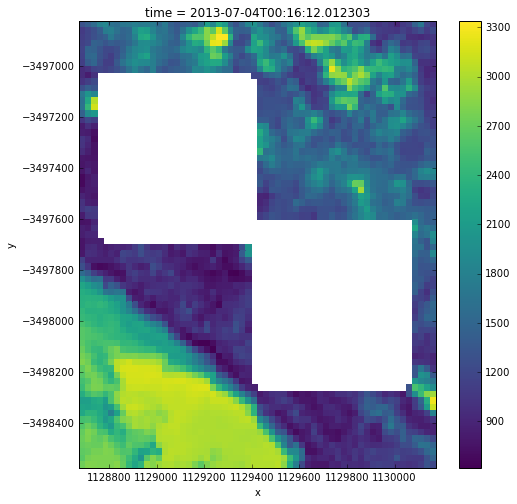

In [9]:
WQ_pqm_xarray[[1],range(595,665),range(240,300)].plot();

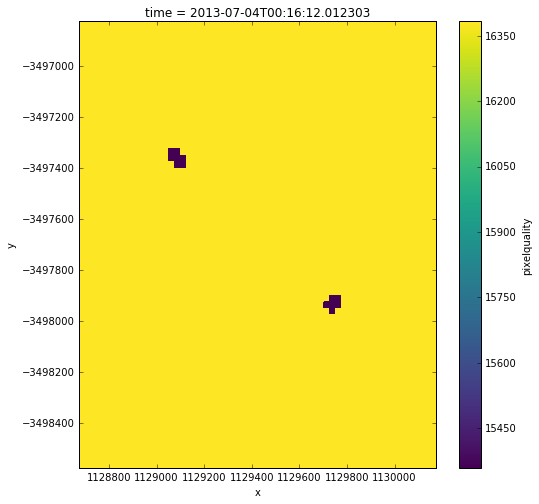

In [10]:
PQ_xarray[[1],range(595,665),range(240,300)].plot();

In [11]:
print( np.unique( PQ_xarray.values[1] ) )
print( [format(ii,'016b') for ii in np.unique(PQ_xarray.values[1])] )
print( '  00----11--------    00----11--------' )
    # help identify the bits of interest: the 2 leading bits are always 0, then come 4
    # could/shadow-related bits, then '11' in the middle (contiguity and land bits),
    # finally followed by saturation bits (one for each band).

[15359 16383]
['0011101111111111', '0011111111111111']
  00----11--------    00----11--------


So there are mainly OK pixels (`0011111111111111`) and some isolated "cloud" pixels (`0011101111111111`). For some reason, the ACCA processing routines identified only a few single pixels here. These are actually unlikely to be cloud-affected, but this helps us determine how the PQ mask is derived nevertheless: a close inspection of the `WQ_pqm_xarray` plot above indicates that the PQ masking operation applies a buffer of +/- 12 pixels around the "dodgy" pixels in the PQ layer. 

The main question here is regarding the square shape used when buffering the PQ data. This is a result of using `scipy`'s `binary_dilation` function with a square structuring element. There is, however, no specific reason why a square structure should be employed. A discussion with GA staff indeed indicated that _"not much thought has gone into the 'Why and how much to dilate/erode', it was simply used to generate [a better mosaic]"_. 

On that basis, a possibly better (i.e. more visually pleasing) approach might be to mask any pixel _within a specific distance_ from the poor-quality pixels. This can be achieved as follows...

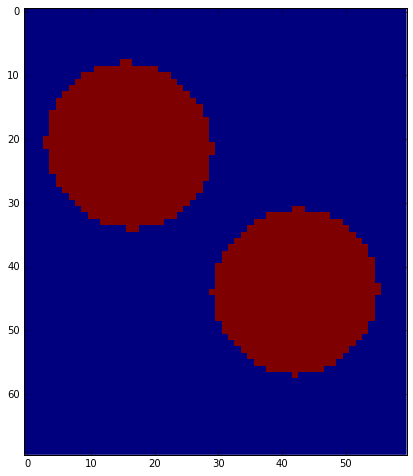

In [12]:
tmp = PQ_xarray[1].values
pq_mask = np.zeros(tmp.shape).astype('bool')
pq_mask[tmp!=16383] = True
pq_mask = expand_mask(pq_mask,12)   # expand mask by given distance
plt.imshow( pq_mask[595:665,240:300], interpolation='none' );

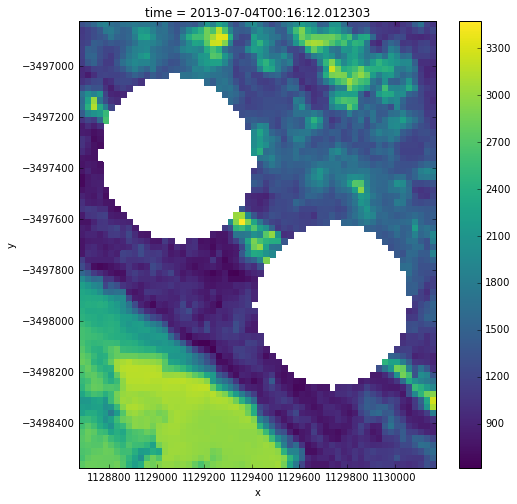

In [13]:
tmp = WQ_xarray[1].values
tmp[pq_mask] = np.nan
WQ_xarray.values[1] = tmp
WQ_xarray[[1],range(595,665),range(240,300)].plot();

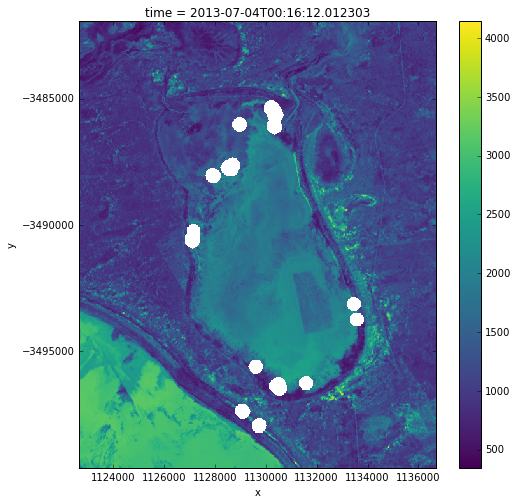

In [14]:
WQ_xarray[[1]].plot();

And now we have round (not square) "clouds". The masked pixels are here all flagged as "clouds" in the PQ layer, so the "swiss-cheese" appearance of the masked dataset, as a result of expanding the PQ mask, is here unavoidable if we work on the basis that the cloud/shadow mask needs to be expanded (due to obvious deficiencies with the ACCA/Fmask algorithms at the edges of the mask)...

On the other hand, note that it does not really make sense to expand the mask if the pixels are _saturated_, _non-land_ or _non-contiguous_ pixels. For instance, a pixel being labelled as non-contiguous (NaN value in one of the bands) does not mean that the surrounding OK (contiguous) pixels should also be masked. Inaccuracies in the ACCA and Fmask algorithms mean that _cloud-affected_ pixels are often missed at the edges of clouds and/or shadows. Expanding the mask for cloud / shadow pixels is thus a good idea in general.

Also, note that when automating this process, checking for _non-contiguous_ and _saturated_  pixels theoretically only needs to consider the bands of interest, which depend on the specific WQ algorithm used (e.g. 'red' and 'green' bands only in a basic 2-band algorithm). In turn, these bands will have different PQ bits in the PQ layer; for instance, the red band corresponds to saturation bit nr. 2 for Landsat 5/7, while this is bit nr. 3 for Landsat 8 (due to the additional coastal band). 


## Deriving a more appropriate PQ mask

On the basis of the above discussion, let's see how we can generate a satisfactory PQ mask. For demonstration, we'll use a couple of dates known to contain various types of PQ-flagged pixels.

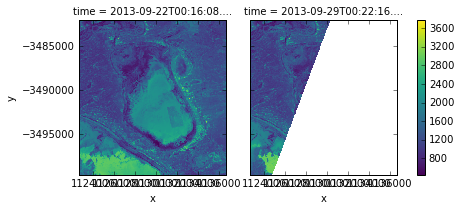

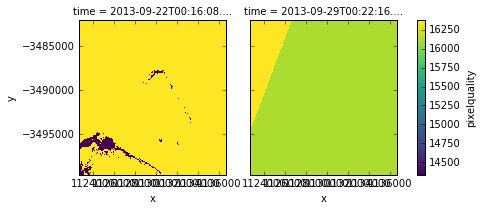

In [15]:
dimensions = { 'lon' : { 'range': ( min(poly_array[:,0])-0.02, max(poly_array[:,0])+0.02 ) },
               'lat' : { 'range': ( max(poly_array[:,1])+0.02, min(poly_array[:,1])-0.02 ) },
               'time': { 'range': ((2013, 9, 20), (2013, 10, 16)) } }

aeB2 = ae.create_array(('LANDSAT_8', 'nbar'), ['band_3'], dimensions, 'aeB2')
aeB3 = ae.create_array(('LANDSAT_8', 'nbar'), ['band_4'], dimensions, 'aeB3')
aePQ = ae.create_array(('LANDSAT_8', 'pqa'), ['pixelquality'], dimensions, 'aePQ')
aeWQ = ae.apply_expression([aeB2, aeB3], '((array1 + array2) * 0.5)', 'aeWQ')
ee.execute_plan(ae.plan)

WQ_xarray = ee.cache['aeWQ']['array_result']['aeWQ'][(1,4),:,:]
PQ_xarray = ee.cache['aePQ']['array_result']['pixelquality'][(1,4),:,:]

# plots of WQ and PQ data:
WQ_xarray.plot(col='time');
PQ_xarray.plot(col='time');

In [16]:
# checking for PQ flags in first date:
print( np.unique( PQ_xarray.values[0] ) )
print( [format(ii,'016b') for ii in np.unique(PQ_xarray.values[0])] )
print( '  00----11--------    00----11--------' )

[14335 16383]
['0011011111111111', '0011111111111111']
  00----11--------    00----11--------


In [17]:
# checking for PQ flags in second date:
print( np.unique( PQ_xarray.values[1] ) )
print( [format(ii,'016b') for ii in np.unique(PQ_xarray.values[1])] )
print( '  00----11--------    00----11--------' )

[16127 16383]
['0011111011111111', '0011111111111111']
  00----11--------    00----11--------


So the first time slice contains clouds and/or shadows, while the second time slice has pixels flagged as non-contiguous (i.e. NaN value in at least one of the bands). As per the discussion above, the non-contiguous pixels (as well as saturated and sea pixels) should theoretically not be expanded, while the cloud/shadow mask should.

### Bit testing

In Python, we can easily test if a bit is set or not, as follows:

In [18]:
value_to_test = 16127   # PQ value for a non-contiguous pixel
bit_to_test = 8   # this is the contiguity bit

if value_to_test & (1<<bit_to_test): print("The bit is set.")   # bit set = OK pixel, i.e. contiguous (good)
else: print("The bit is not set.")   # bit not set = non-contiguous pixel (bad)

The bit is not set.


In [19]:
value_to_test = 16383   # PQ value for all-OK pixel

if value_to_test & (1<<bit_to_test): print("The bit is set.")   # bit set = OK pixel, i.e. contiguous (good)
else: print("The bit is not set.")   # bit not set = non-contiguous pixel (bad)

The bit is set.


What we also need now is a test to tell us if any of several bits are set, e.g. to test if any of the cloud-related bits are set to 0. A bit mask for this operation can be formed as follows:

In [20]:
cloud_bit_mask = (1<<10 | 1<<11 | 1<<12 | 1<<13)
format( cloud_bit_mask, '016b' )

'0011110000000000'

Applied to a given PQ flag value, we can isolate the cloud pixels:

In [21]:
value_to_test = 14335
tmp = value_to_test & cloud_bit_mask
format(tmp,'016b')

'0011010000000000'

... and then check whether any of those cloud pixels is set to 0 (indicating the presence of cloud and/or shadow):

In [22]:
if tmp==cloud_bit_mask: print ("We have no cloud/shadow.")   # all cloud/shadow bits set to 1 (good)
else: print( "There is cloud and/or shadow." )   # some cloud/shadow bits set to 0 (bad)

There is cloud and/or shadow.


In [23]:
value_to_test = 16383
tmp = value_to_test & cloud_bit_mask
if tmp==cloud_bit_mask: print ("We have no cloud/shadow.")   # all cloud/shadow bits set to 1 (good)
else: print( "There is cloud and/or shadow." )   # some cloud/shadow bits set to 0 (bad)

We have no cloud/shadow.


### PQ mask

So we can now produce a proper mask on the basis of the PQ time series for each date. First, let's define the generic PQ masking bits:

In [24]:
red_sat_bit = 3   # saturation bits
green_sat_bit = 2
contig_bit = 8
land_bit = 9      # land/sea bit
cloud_bit1 = 10   # cloud/shadow bits
cloud_bit2 = 11
cloud_bit3 = 12
cloud_bit4 = 13

cloud_bit_mask = (1<<cloud_bit1 | 1<<cloud_bit2 | 1<<cloud_bit3 | 1<<cloud_bit4)
other_bit_mask = (1<<red_sat_bit | 1<<green_sat_bit | 1<<contig_bit | 1<<land_bit)

And then, apply the cloud mask (with expansion) and saturated/sea/contiguity mask (not expanded) to the data:

In [25]:
idx = 0
tmp = PQ_xarray[idx].values

# expanded cloud mask:
msk = ( (tmp & cloud_bit_mask)!=cloud_bit_mask ).astype(bool)
msk = expand_mask(msk,12)

# merge with 'others' mask (saturated, sea, contiguity):
msk = msk | ( (tmp & other_bit_mask)!=other_bit_mask ).astype(bool)

WQ_xarray.values[idx][msk] = np.nan

In [26]:
idx = 1
tmp = PQ_xarray[idx].values
msk = ( (tmp & cloud_bit_mask)!=cloud_bit_mask ).astype(bool)
msk = expand_mask(msk,12)
msk = msk | ( (tmp & other_bit_mask)!=other_bit_mask ).astype(bool)
WQ_xarray.values[idx][msk] = np.nan

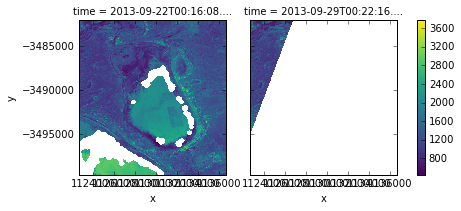

In [27]:
WQ_xarray.plot(col='time');

The cloud mask in the first time slice has been correctely buffered by 12 pixels, while the second time slice has had data masked as per the actual (not expanded) non-contiguous mask.

Note that in the second time slice, seemingly valid WQ data has been removed by the non-contiguous mask (see non-masked WQ plot above). In other words, we have "valid" NBAR data in the red and green bands, thus allowing us to derive "valid" WQ information, in a region where the PQ mask indicates we should mask the data. Thus, removing this "valid" data as per the PQ mask can seem somewhat detrimental.

The issue here is that the PQ information may be impossible to derive when bands are missing. For instance, the Fmask and ACCA algorithms require certain bands to be able to derive the cloud and shadow masks. So even though certain bands may contain data in areas of non-contiguous pixels, the cloud and shadow PQ information may thus be unavailable, thereby implicitely rendering such regions "invalid".


## Manual PQ masking of time series data

We can now look at how to automate our own masking process on a time series of Landsat data. In addition to the issue of "square clouds" highlighted above, this manual processing also enables us to deal with missing time slices of PQ data, which is an issue encountered with the current database in earlier notebooks.

For this, we'll use a time window where we know such an issue arises.

In [28]:
dimensions = { 'lon' : { 'range': ( min(poly_array[:,0])-0.02, max(poly_array[:,0])+0.02 ) },
               'lat' : { 'range': ( max(poly_array[:,1])+0.02, min(poly_array[:,1])-0.02 ) },
               'time': { 'range': ((2013, 9, 20), (2013, 10, 16)) } }

In [29]:
aeB2 = ae.create_array(('LANDSAT_8', 'nbar'), ['band_3'], dimensions, 'aeB2')
aeB3 = ae.create_array(('LANDSAT_8', 'nbar'), ['band_4'], dimensions, 'aeB3')
aePQ = ae.create_array(('LANDSAT_8', 'pqa'), ['pixelquality'], dimensions, 'aePQ')
aeWQ = ae.apply_expression([aeB2, aeB3], '((array1 + array2) * 0.5)', 'aeWQ')
ee.execute_plan(ae.plan)

In [30]:
print( "Nr. available NBAR dates:", ee.cache['aeWQ']['array_result']['aeWQ'].shape[0])
print( "Nr. available PQ dates:", ee.cache['aePQ']['array_result']['pixelquality'].shape[0])

Nr. available NBAR dates: 9
Nr. available PQ dates: 8


So as found earlier, for some reason there is here one fewer time slice of PQ data compared to the NBAR / WQ dataset... 

In [31]:
WQ_xarray = ee.cache['aeWQ']['array_result']['aeWQ']
PQ_xarray = ee.cache['aePQ']['array_result']['pixelquality']

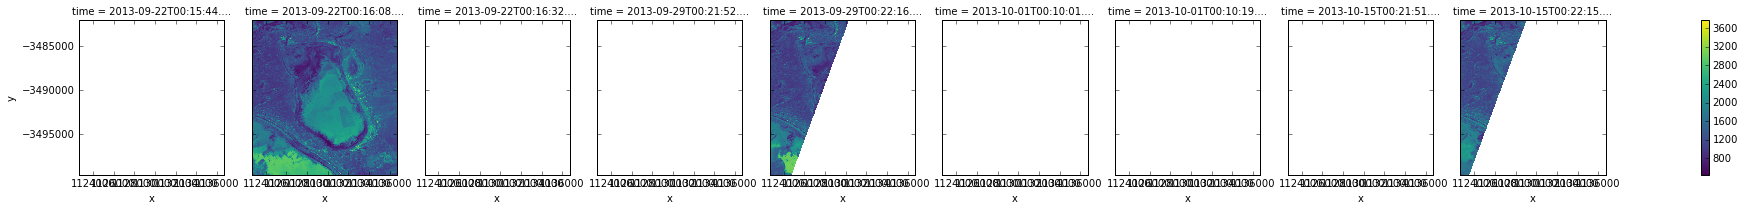

In [32]:
WQ_xarray.plot(col='time');

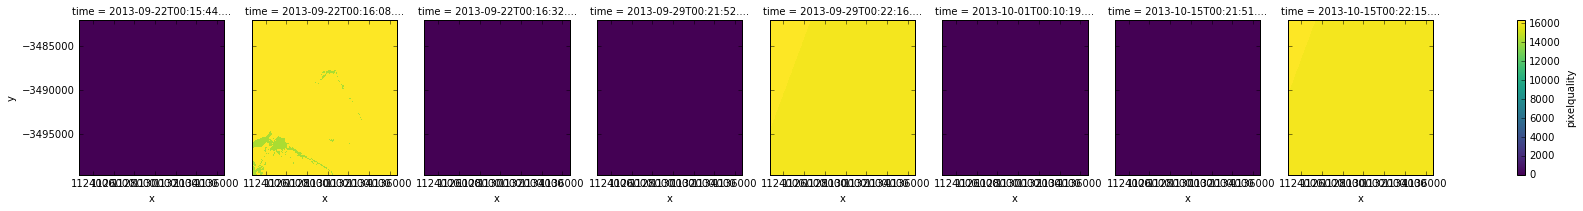

In [33]:
PQ_xarray.plot(col='time');

Manual PQ masking of this dataset could proceed as follows:

In [34]:
# Manual PQ masking of the data:
n_dates = WQ_xarray.shape[0]
rem_ind = np.zeros(n_dates).astype('bool')   # keep track of which dates (if any) to remove
PQ_dates = PQ_xarray['time'].values

for nn in range(n_dates):
    cur_date = WQ_xarray['time'].values[nn]   # current date
    idx = np.where(PQ_dates==cur_date)[0]
    if len(idx)==0:    # time slice not found in PQ dataset 
        rem_ind[nn] = True   # remove date from the time series as unable to properly mask it
    else:
        tmp = PQ_xarray[idx[0]].values
        pq_mask = ( (tmp & cloud_bit_mask)!=cloud_bit_mask ).astype(bool)
        pq_mask = expand_mask(pq_mask,12)   # expand mask by given distance
        pq_mask = pq_mask | ( (tmp & other_bit_mask)!=other_bit_mask ).astype(bool)
        WQ_xarray.values[nn][pq_mask] = np.nan   # mask the dataset for current time slice

WQ_xarray = WQ_xarray[~rem_ind]

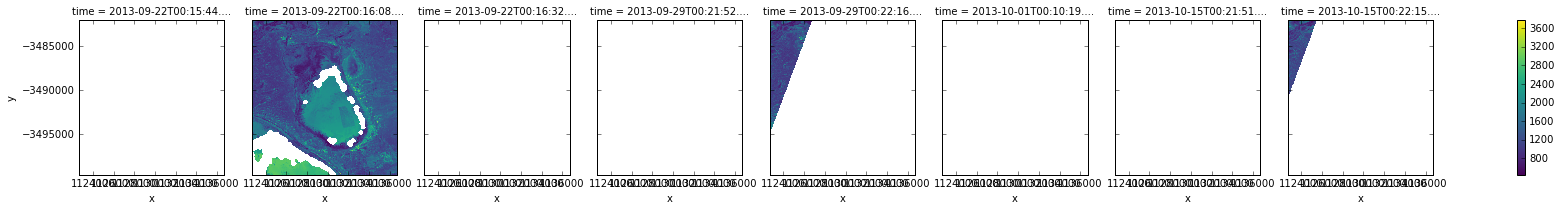

In [35]:
WQ_xarray.plot(col='time');

We have now properly masked our WQ data while dealing with the missing time slice of PQ information. We can now further merge the duplicated time slices and remove those with no valid data, as per our standard processing routine:

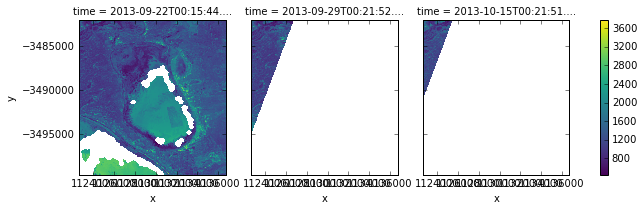

In [36]:
WQ_xarray = merge_dup_dates( WQ_xarray.load() )

tmp = np.where( ( (~np.isnan(WQ_xarray)).sum('x').sum('y')!=0 ).values )[0]
WQ_xarray = WQ_xarray[tmp]

WQ_xarray.plot(col='time');